In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [3]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [4]:
# Demonstrate the inplace operation issue

# class Dynamics(nn.Module):
#
#     def __init__(self):
#         super(Dynamics, self).__init__()
#
#     @staticmethod
#     def forward(state, action):
#
#         """
#         action: thrust or no thrust
#         state[0] = y
#         state[1] = y_dot
#         """
#
#         # Update velocity using element-wise operation. This leads to an error from PyTorch.
#         state[1] = state[1] + GRAVITY_ACCEL * FRAME_TIME - BOOST_ACCEL * FRAME_TIME * action
#
#         # Update state
#         step_mat = t.tensor([[1., FRAME_TIME],
#                             [0., 1.]])
#         state = t.matmul(step_mat, state)
#
#         return state

In [5]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [6]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [7]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            cor = self.visualize()
        tim = np.arange(0,len(cor))*0.1
        print('Landing Trajectory:')
        plt.plot(tim, cor)
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()
        return x

tensor([0.4492], grad_fn=<SigmoidBackward>)
tensor([0.4492], grad_fn=<SigmoidBackward>)
tensor([0.4491], grad_fn=<SigmoidBackward>)
tensor([0.4491], grad_fn=<SigmoidBackward>)
tensor([0.4490], grad_fn=<SigmoidBackward>)
tensor([0.4490], grad_fn=<SigmoidBackward>)
tensor([0.4489], grad_fn=<SigmoidBackward>)
tensor([0.4489], grad_fn=<SigmoidBackward>)
tensor([0.4488], grad_fn=<SigmoidBackward>)
tensor([0.4487], grad_fn=<SigmoidBackward>)
tensor([0.4487], grad_fn=<SigmoidBackward>)
tensor([0.4486], grad_fn=<SigmoidBackward>)
tensor([0.4485], grad_fn=<SigmoidBackward>)
tensor([0.4484], grad_fn=<SigmoidBackward>)
tensor([0.4484], grad_fn=<SigmoidBackward>)
tensor([0.4483], grad_fn=<SigmoidBackward>)
tensor([0.4482], grad_fn=<SigmoidBackward>)
tensor([0.4481], grad_fn=<SigmoidBackward>)
tensor([0.4480], grad_fn=<SigmoidBackward>)
tensor([0.4479], grad_fn=<SigmoidBackward>)
tensor([0.4477], grad_fn=<SigmoidBackward>)
tensor([0.4476], grad_fn=<SigmoidBackward>)
tensor([0.4475], grad_fn=<Sigmoi

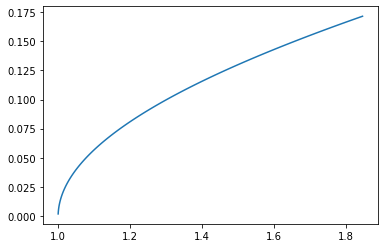

tensor([0.5763], grad_fn=<SigmoidBackward>)
tensor([0.5763], grad_fn=<SigmoidBackward>)
tensor([0.5762], grad_fn=<SigmoidBackward>)
tensor([0.5762], grad_fn=<SigmoidBackward>)
tensor([0.5761], grad_fn=<SigmoidBackward>)
tensor([0.5760], grad_fn=<SigmoidBackward>)
tensor([0.5760], grad_fn=<SigmoidBackward>)
tensor([0.5759], grad_fn=<SigmoidBackward>)
tensor([0.5759], grad_fn=<SigmoidBackward>)
tensor([0.5758], grad_fn=<SigmoidBackward>)
tensor([0.5757], grad_fn=<SigmoidBackward>)
tensor([0.5757], grad_fn=<SigmoidBackward>)
tensor([0.5756], grad_fn=<SigmoidBackward>)
tensor([0.5755], grad_fn=<SigmoidBackward>)
tensor([0.5755], grad_fn=<SigmoidBackward>)
tensor([0.5754], grad_fn=<SigmoidBackward>)
tensor([0.5753], grad_fn=<SigmoidBackward>)
tensor([0.5753], grad_fn=<SigmoidBackward>)
tensor([0.5752], grad_fn=<SigmoidBackward>)
tensor([0.5751], grad_fn=<SigmoidBackward>)
tensor([0.5750], grad_fn=<SigmoidBackward>)
tensor([0.5750], grad_fn=<SigmoidBackward>)
tensor([0.5749], grad_fn=<Sigmoi

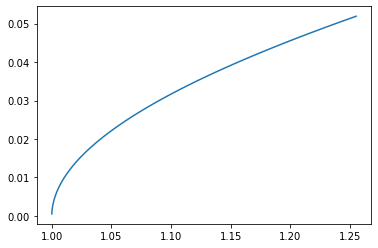

tensor([0.6396], grad_fn=<SigmoidBackward>)
tensor([0.6396], grad_fn=<SigmoidBackward>)
tensor([0.6396], grad_fn=<SigmoidBackward>)
tensor([0.6395], grad_fn=<SigmoidBackward>)
tensor([0.6395], grad_fn=<SigmoidBackward>)
tensor([0.6395], grad_fn=<SigmoidBackward>)
tensor([0.6395], grad_fn=<SigmoidBackward>)
tensor([0.6395], grad_fn=<SigmoidBackward>)
tensor([0.6394], grad_fn=<SigmoidBackward>)
tensor([0.6394], grad_fn=<SigmoidBackward>)
tensor([0.6394], grad_fn=<SigmoidBackward>)
tensor([0.6394], grad_fn=<SigmoidBackward>)
tensor([0.6393], grad_fn=<SigmoidBackward>)
tensor([0.6393], grad_fn=<SigmoidBackward>)
tensor([0.6393], grad_fn=<SigmoidBackward>)
tensor([0.6393], grad_fn=<SigmoidBackward>)
tensor([0.6392], grad_fn=<SigmoidBackward>)
tensor([0.6392], grad_fn=<SigmoidBackward>)
tensor([0.6392], grad_fn=<SigmoidBackward>)
tensor([0.6392], grad_fn=<SigmoidBackward>)
tensor([0.6391], grad_fn=<SigmoidBackward>)
tensor([0.6391], grad_fn=<SigmoidBackward>)
tensor([0.6391], grad_fn=<Sigmoi

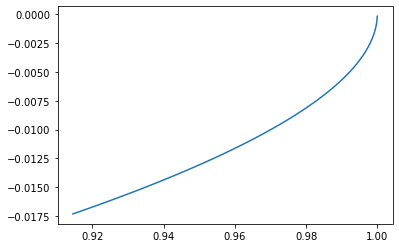

tensor([0.6757], grad_fn=<SigmoidBackward>)
tensor([0.6757], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6758], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<SigmoidBackward>)
tensor([0.6759], grad_fn=<Sigmoi

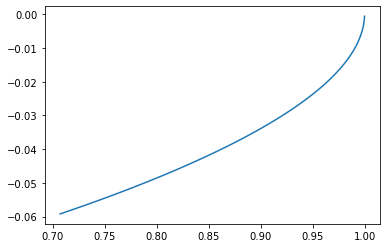

tensor([0.6978], grad_fn=<SigmoidBackward>)
tensor([0.6979], grad_fn=<SigmoidBackward>)
tensor([0.6979], grad_fn=<SigmoidBackward>)
tensor([0.6979], grad_fn=<SigmoidBackward>)
tensor([0.6979], grad_fn=<SigmoidBackward>)
tensor([0.6979], grad_fn=<SigmoidBackward>)
tensor([0.6980], grad_fn=<SigmoidBackward>)
tensor([0.6980], grad_fn=<SigmoidBackward>)
tensor([0.6980], grad_fn=<SigmoidBackward>)
tensor([0.6980], grad_fn=<SigmoidBackward>)
tensor([0.6981], grad_fn=<SigmoidBackward>)
tensor([0.6981], grad_fn=<SigmoidBackward>)
tensor([0.6981], grad_fn=<SigmoidBackward>)
tensor([0.6981], grad_fn=<SigmoidBackward>)
tensor([0.6982], grad_fn=<SigmoidBackward>)
tensor([0.6982], grad_fn=<SigmoidBackward>)
tensor([0.6982], grad_fn=<SigmoidBackward>)
tensor([0.6983], grad_fn=<SigmoidBackward>)
tensor([0.6983], grad_fn=<SigmoidBackward>)
tensor([0.6983], grad_fn=<SigmoidBackward>)
tensor([0.6984], grad_fn=<SigmoidBackward>)
tensor([0.6984], grad_fn=<SigmoidBackward>)
tensor([0.6984], grad_fn=<Sigmoi

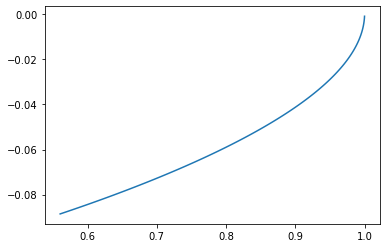

tensor([0.7134], grad_fn=<SigmoidBackward>)
tensor([0.7135], grad_fn=<SigmoidBackward>)
tensor([0.7135], grad_fn=<SigmoidBackward>)
tensor([0.7135], grad_fn=<SigmoidBackward>)
tensor([0.7136], grad_fn=<SigmoidBackward>)
tensor([0.7136], grad_fn=<SigmoidBackward>)
tensor([0.7136], grad_fn=<SigmoidBackward>)
tensor([0.7137], grad_fn=<SigmoidBackward>)
tensor([0.7137], grad_fn=<SigmoidBackward>)
tensor([0.7137], grad_fn=<SigmoidBackward>)
tensor([0.7138], grad_fn=<SigmoidBackward>)
tensor([0.7138], grad_fn=<SigmoidBackward>)
tensor([0.7139], grad_fn=<SigmoidBackward>)
tensor([0.7139], grad_fn=<SigmoidBackward>)
tensor([0.7139], grad_fn=<SigmoidBackward>)
tensor([0.7140], grad_fn=<SigmoidBackward>)
tensor([0.7140], grad_fn=<SigmoidBackward>)
tensor([0.7141], grad_fn=<SigmoidBackward>)
tensor([0.7141], grad_fn=<SigmoidBackward>)
tensor([0.7142], grad_fn=<SigmoidBackward>)
tensor([0.7142], grad_fn=<SigmoidBackward>)
tensor([0.7143], grad_fn=<SigmoidBackward>)
tensor([0.7143], grad_fn=<Sigmoi

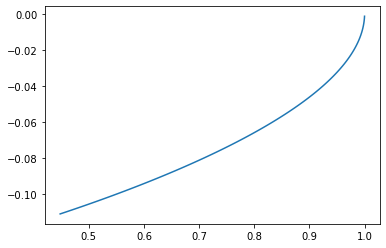

tensor([0.7254], grad_fn=<SigmoidBackward>)
tensor([0.7254], grad_fn=<SigmoidBackward>)
tensor([0.7255], grad_fn=<SigmoidBackward>)
tensor([0.7255], grad_fn=<SigmoidBackward>)
tensor([0.7255], grad_fn=<SigmoidBackward>)
tensor([0.7256], grad_fn=<SigmoidBackward>)
tensor([0.7256], grad_fn=<SigmoidBackward>)
tensor([0.7257], grad_fn=<SigmoidBackward>)
tensor([0.7257], grad_fn=<SigmoidBackward>)
tensor([0.7258], grad_fn=<SigmoidBackward>)
tensor([0.7258], grad_fn=<SigmoidBackward>)
tensor([0.7259], grad_fn=<SigmoidBackward>)
tensor([0.7259], grad_fn=<SigmoidBackward>)
tensor([0.7260], grad_fn=<SigmoidBackward>)
tensor([0.7260], grad_fn=<SigmoidBackward>)
tensor([0.7261], grad_fn=<SigmoidBackward>)
tensor([0.7261], grad_fn=<SigmoidBackward>)
tensor([0.7262], grad_fn=<SigmoidBackward>)
tensor([0.7263], grad_fn=<SigmoidBackward>)
tensor([0.7263], grad_fn=<SigmoidBackward>)
tensor([0.7264], grad_fn=<SigmoidBackward>)
tensor([0.7264], grad_fn=<SigmoidBackward>)
tensor([0.7265], grad_fn=<Sigmoi

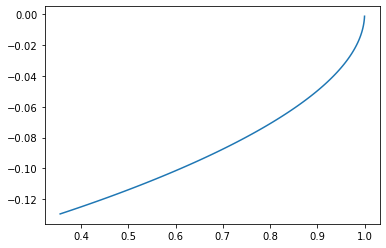

tensor([0.7352], grad_fn=<SigmoidBackward>)
tensor([0.7352], grad_fn=<SigmoidBackward>)
tensor([0.7353], grad_fn=<SigmoidBackward>)
tensor([0.7353], grad_fn=<SigmoidBackward>)
tensor([0.7354], grad_fn=<SigmoidBackward>)
tensor([0.7354], grad_fn=<SigmoidBackward>)
tensor([0.7355], grad_fn=<SigmoidBackward>)
tensor([0.7355], grad_fn=<SigmoidBackward>)
tensor([0.7356], grad_fn=<SigmoidBackward>)
tensor([0.7356], grad_fn=<SigmoidBackward>)
tensor([0.7357], grad_fn=<SigmoidBackward>)
tensor([0.7357], grad_fn=<SigmoidBackward>)
tensor([0.7358], grad_fn=<SigmoidBackward>)
tensor([0.7359], grad_fn=<SigmoidBackward>)
tensor([0.7359], grad_fn=<SigmoidBackward>)
tensor([0.7360], grad_fn=<SigmoidBackward>)
tensor([0.7361], grad_fn=<SigmoidBackward>)
tensor([0.7361], grad_fn=<SigmoidBackward>)
tensor([0.7362], grad_fn=<SigmoidBackward>)
tensor([0.7363], grad_fn=<SigmoidBackward>)
tensor([0.7363], grad_fn=<SigmoidBackward>)
tensor([0.7364], grad_fn=<SigmoidBackward>)
tensor([0.7365], grad_fn=<Sigmoi

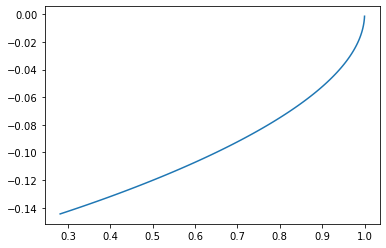

tensor([0.7431], grad_fn=<SigmoidBackward>)
tensor([0.7432], grad_fn=<SigmoidBackward>)
tensor([0.7432], grad_fn=<SigmoidBackward>)
tensor([0.7432], grad_fn=<SigmoidBackward>)
tensor([0.7433], grad_fn=<SigmoidBackward>)
tensor([0.7433], grad_fn=<SigmoidBackward>)
tensor([0.7434], grad_fn=<SigmoidBackward>)
tensor([0.7435], grad_fn=<SigmoidBackward>)
tensor([0.7435], grad_fn=<SigmoidBackward>)
tensor([0.7436], grad_fn=<SigmoidBackward>)
tensor([0.7436], grad_fn=<SigmoidBackward>)
tensor([0.7437], grad_fn=<SigmoidBackward>)
tensor([0.7438], grad_fn=<SigmoidBackward>)
tensor([0.7438], grad_fn=<SigmoidBackward>)
tensor([0.7439], grad_fn=<SigmoidBackward>)
tensor([0.7440], grad_fn=<SigmoidBackward>)
tensor([0.7440], grad_fn=<SigmoidBackward>)
tensor([0.7441], grad_fn=<SigmoidBackward>)
tensor([0.7442], grad_fn=<SigmoidBackward>)
tensor([0.7443], grad_fn=<SigmoidBackward>)
tensor([0.7444], grad_fn=<SigmoidBackward>)
tensor([0.7445], grad_fn=<SigmoidBackward>)
tensor([0.7445], grad_fn=<Sigmoi

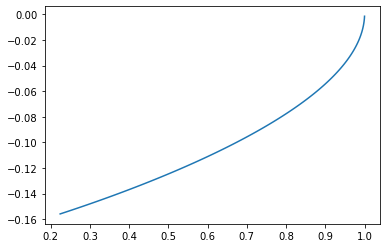

tensor([0.7492], grad_fn=<SigmoidBackward>)
tensor([0.7493], grad_fn=<SigmoidBackward>)
tensor([0.7493], grad_fn=<SigmoidBackward>)
tensor([0.7494], grad_fn=<SigmoidBackward>)
tensor([0.7494], grad_fn=<SigmoidBackward>)
tensor([0.7495], grad_fn=<SigmoidBackward>)
tensor([0.7495], grad_fn=<SigmoidBackward>)
tensor([0.7496], grad_fn=<SigmoidBackward>)
tensor([0.7496], grad_fn=<SigmoidBackward>)
tensor([0.7497], grad_fn=<SigmoidBackward>)
tensor([0.7498], grad_fn=<SigmoidBackward>)
tensor([0.7498], grad_fn=<SigmoidBackward>)
tensor([0.7499], grad_fn=<SigmoidBackward>)
tensor([0.7500], grad_fn=<SigmoidBackward>)
tensor([0.7500], grad_fn=<SigmoidBackward>)
tensor([0.7501], grad_fn=<SigmoidBackward>)
tensor([0.7502], grad_fn=<SigmoidBackward>)
tensor([0.7503], grad_fn=<SigmoidBackward>)
tensor([0.7504], grad_fn=<SigmoidBackward>)
tensor([0.7505], grad_fn=<SigmoidBackward>)
tensor([0.7506], grad_fn=<SigmoidBackward>)
tensor([0.7506], grad_fn=<SigmoidBackward>)
tensor([0.7507], grad_fn=<Sigmoi

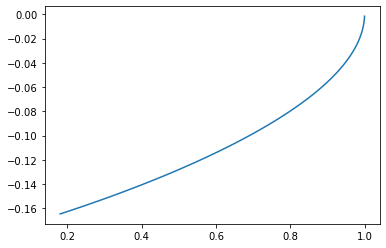

tensor([0.7539], grad_fn=<SigmoidBackward>)
tensor([0.7539], grad_fn=<SigmoidBackward>)
tensor([0.7540], grad_fn=<SigmoidBackward>)
tensor([0.7540], grad_fn=<SigmoidBackward>)
tensor([0.7541], grad_fn=<SigmoidBackward>)
tensor([0.7541], grad_fn=<SigmoidBackward>)
tensor([0.7542], grad_fn=<SigmoidBackward>)
tensor([0.7542], grad_fn=<SigmoidBackward>)
tensor([0.7543], grad_fn=<SigmoidBackward>)
tensor([0.7544], grad_fn=<SigmoidBackward>)
tensor([0.7544], grad_fn=<SigmoidBackward>)
tensor([0.7545], grad_fn=<SigmoidBackward>)
tensor([0.7546], grad_fn=<SigmoidBackward>)
tensor([0.7546], grad_fn=<SigmoidBackward>)
tensor([0.7547], grad_fn=<SigmoidBackward>)
tensor([0.7548], grad_fn=<SigmoidBackward>)
tensor([0.7549], grad_fn=<SigmoidBackward>)
tensor([0.7550], grad_fn=<SigmoidBackward>)
tensor([0.7551], grad_fn=<SigmoidBackward>)
tensor([0.7552], grad_fn=<SigmoidBackward>)
tensor([0.7552], grad_fn=<SigmoidBackward>)
tensor([0.7553], grad_fn=<SigmoidBackward>)
tensor([0.7554], grad_fn=<Sigmoi

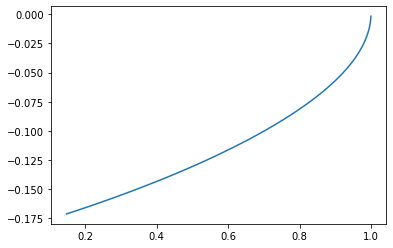

tensor([0.7575], grad_fn=<SigmoidBackward>)
tensor([0.7575], grad_fn=<SigmoidBackward>)
tensor([0.7576], grad_fn=<SigmoidBackward>)
tensor([0.7576], grad_fn=<SigmoidBackward>)
tensor([0.7577], grad_fn=<SigmoidBackward>)
tensor([0.7577], grad_fn=<SigmoidBackward>)
tensor([0.7578], grad_fn=<SigmoidBackward>)
tensor([0.7578], grad_fn=<SigmoidBackward>)
tensor([0.7579], grad_fn=<SigmoidBackward>)
tensor([0.7580], grad_fn=<SigmoidBackward>)
tensor([0.7580], grad_fn=<SigmoidBackward>)
tensor([0.7581], grad_fn=<SigmoidBackward>)
tensor([0.7582], grad_fn=<SigmoidBackward>)
tensor([0.7583], grad_fn=<SigmoidBackward>)
tensor([0.7583], grad_fn=<SigmoidBackward>)
tensor([0.7584], grad_fn=<SigmoidBackward>)
tensor([0.7585], grad_fn=<SigmoidBackward>)
tensor([0.7586], grad_fn=<SigmoidBackward>)
tensor([0.7587], grad_fn=<SigmoidBackward>)
tensor([0.7588], grad_fn=<SigmoidBackward>)
tensor([0.7589], grad_fn=<SigmoidBackward>)
tensor([0.7590], grad_fn=<SigmoidBackward>)
tensor([0.7591], grad_fn=<Sigmoi

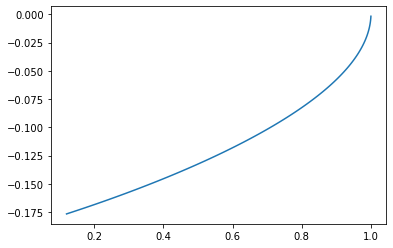

tensor([0.7604], grad_fn=<SigmoidBackward>)
tensor([0.7604], grad_fn=<SigmoidBackward>)
tensor([0.7604], grad_fn=<SigmoidBackward>)
tensor([0.7605], grad_fn=<SigmoidBackward>)
tensor([0.7605], grad_fn=<SigmoidBackward>)
tensor([0.7606], grad_fn=<SigmoidBackward>)
tensor([0.7607], grad_fn=<SigmoidBackward>)
tensor([0.7607], grad_fn=<SigmoidBackward>)
tensor([0.7608], grad_fn=<SigmoidBackward>)
tensor([0.7608], grad_fn=<SigmoidBackward>)
tensor([0.7609], grad_fn=<SigmoidBackward>)
tensor([0.7610], grad_fn=<SigmoidBackward>)
tensor([0.7611], grad_fn=<SigmoidBackward>)
tensor([0.7611], grad_fn=<SigmoidBackward>)
tensor([0.7612], grad_fn=<SigmoidBackward>)
tensor([0.7613], grad_fn=<SigmoidBackward>)
tensor([0.7614], grad_fn=<SigmoidBackward>)
tensor([0.7615], grad_fn=<SigmoidBackward>)
tensor([0.7616], grad_fn=<SigmoidBackward>)
tensor([0.7617], grad_fn=<SigmoidBackward>)
tensor([0.7618], grad_fn=<SigmoidBackward>)
tensor([0.7619], grad_fn=<SigmoidBackward>)
tensor([0.7620], grad_fn=<Sigmoi

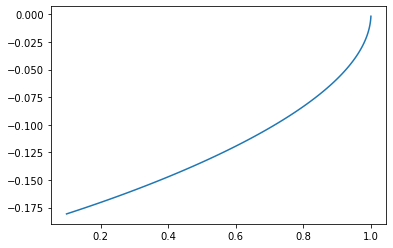

tensor([0.7627], grad_fn=<SigmoidBackward>)
tensor([0.7627], grad_fn=<SigmoidBackward>)
tensor([0.7627], grad_fn=<SigmoidBackward>)
tensor([0.7628], grad_fn=<SigmoidBackward>)
tensor([0.7628], grad_fn=<SigmoidBackward>)
tensor([0.7629], grad_fn=<SigmoidBackward>)
tensor([0.7629], grad_fn=<SigmoidBackward>)
tensor([0.7630], grad_fn=<SigmoidBackward>)
tensor([0.7631], grad_fn=<SigmoidBackward>)
tensor([0.7631], grad_fn=<SigmoidBackward>)
tensor([0.7632], grad_fn=<SigmoidBackward>)
tensor([0.7633], grad_fn=<SigmoidBackward>)
tensor([0.7633], grad_fn=<SigmoidBackward>)
tensor([0.7634], grad_fn=<SigmoidBackward>)
tensor([0.7635], grad_fn=<SigmoidBackward>)
tensor([0.7636], grad_fn=<SigmoidBackward>)
tensor([0.7637], grad_fn=<SigmoidBackward>)
tensor([0.7638], grad_fn=<SigmoidBackward>)
tensor([0.7639], grad_fn=<SigmoidBackward>)
tensor([0.7640], grad_fn=<SigmoidBackward>)
tensor([0.7641], grad_fn=<SigmoidBackward>)
tensor([0.7642], grad_fn=<SigmoidBackward>)
tensor([0.7643], grad_fn=<Sigmoi

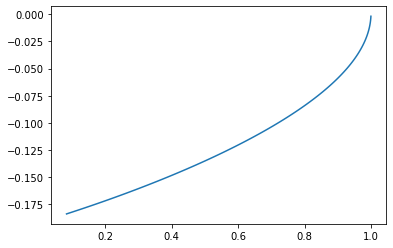

tensor([0.7644], grad_fn=<SigmoidBackward>)
tensor([0.7645], grad_fn=<SigmoidBackward>)
tensor([0.7645], grad_fn=<SigmoidBackward>)
tensor([0.7645], grad_fn=<SigmoidBackward>)
tensor([0.7646], grad_fn=<SigmoidBackward>)
tensor([0.7646], grad_fn=<SigmoidBackward>)
tensor([0.7647], grad_fn=<SigmoidBackward>)
tensor([0.7647], grad_fn=<SigmoidBackward>)
tensor([0.7648], grad_fn=<SigmoidBackward>)
tensor([0.7649], grad_fn=<SigmoidBackward>)
tensor([0.7649], grad_fn=<SigmoidBackward>)
tensor([0.7650], grad_fn=<SigmoidBackward>)
tensor([0.7651], grad_fn=<SigmoidBackward>)
tensor([0.7652], grad_fn=<SigmoidBackward>)
tensor([0.7652], grad_fn=<SigmoidBackward>)
tensor([0.7653], grad_fn=<SigmoidBackward>)
tensor([0.7654], grad_fn=<SigmoidBackward>)
tensor([0.7655], grad_fn=<SigmoidBackward>)
tensor([0.7656], grad_fn=<SigmoidBackward>)
tensor([0.7657], grad_fn=<SigmoidBackward>)
tensor([0.7658], grad_fn=<SigmoidBackward>)
tensor([0.7659], grad_fn=<SigmoidBackward>)
tensor([0.7660], grad_fn=<Sigmoi

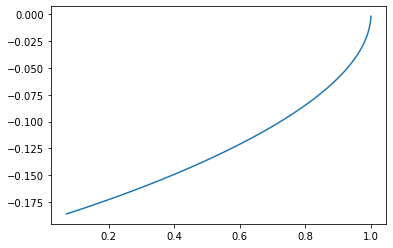

tensor([0.7657], grad_fn=<SigmoidBackward>)
tensor([0.7658], grad_fn=<SigmoidBackward>)
tensor([0.7658], grad_fn=<SigmoidBackward>)
tensor([0.7659], grad_fn=<SigmoidBackward>)
tensor([0.7659], grad_fn=<SigmoidBackward>)
tensor([0.7660], grad_fn=<SigmoidBackward>)
tensor([0.7660], grad_fn=<SigmoidBackward>)
tensor([0.7661], grad_fn=<SigmoidBackward>)
tensor([0.7661], grad_fn=<SigmoidBackward>)
tensor([0.7662], grad_fn=<SigmoidBackward>)
tensor([0.7663], grad_fn=<SigmoidBackward>)
tensor([0.7663], grad_fn=<SigmoidBackward>)
tensor([0.7664], grad_fn=<SigmoidBackward>)
tensor([0.7665], grad_fn=<SigmoidBackward>)
tensor([0.7666], grad_fn=<SigmoidBackward>)
tensor([0.7666], grad_fn=<SigmoidBackward>)
tensor([0.7667], grad_fn=<SigmoidBackward>)
tensor([0.7668], grad_fn=<SigmoidBackward>)
tensor([0.7669], grad_fn=<SigmoidBackward>)
tensor([0.7670], grad_fn=<SigmoidBackward>)
tensor([0.7671], grad_fn=<SigmoidBackward>)
tensor([0.7672], grad_fn=<SigmoidBackward>)
tensor([0.7673], grad_fn=<Sigmoi

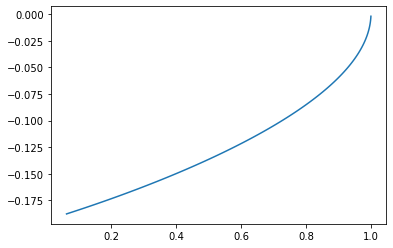

tensor([0.7668], grad_fn=<SigmoidBackward>)
tensor([0.7668], grad_fn=<SigmoidBackward>)
tensor([0.7668], grad_fn=<SigmoidBackward>)
tensor([0.7669], grad_fn=<SigmoidBackward>)
tensor([0.7669], grad_fn=<SigmoidBackward>)
tensor([0.7670], grad_fn=<SigmoidBackward>)
tensor([0.7670], grad_fn=<SigmoidBackward>)
tensor([0.7671], grad_fn=<SigmoidBackward>)
tensor([0.7671], grad_fn=<SigmoidBackward>)
tensor([0.7672], grad_fn=<SigmoidBackward>)
tensor([0.7673], grad_fn=<SigmoidBackward>)
tensor([0.7673], grad_fn=<SigmoidBackward>)
tensor([0.7674], grad_fn=<SigmoidBackward>)
tensor([0.7675], grad_fn=<SigmoidBackward>)
tensor([0.7676], grad_fn=<SigmoidBackward>)
tensor([0.7676], grad_fn=<SigmoidBackward>)
tensor([0.7677], grad_fn=<SigmoidBackward>)
tensor([0.7678], grad_fn=<SigmoidBackward>)
tensor([0.7679], grad_fn=<SigmoidBackward>)
tensor([0.7680], grad_fn=<SigmoidBackward>)
tensor([0.7681], grad_fn=<SigmoidBackward>)
tensor([0.7682], grad_fn=<SigmoidBackward>)
tensor([0.7683], grad_fn=<Sigmoi

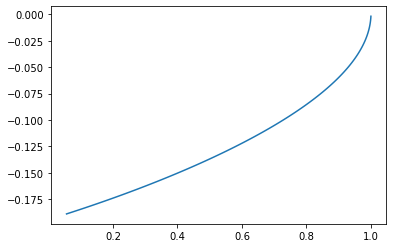

tensor([0.7676], grad_fn=<SigmoidBackward>)
tensor([0.7676], grad_fn=<SigmoidBackward>)
tensor([0.7677], grad_fn=<SigmoidBackward>)
tensor([0.7677], grad_fn=<SigmoidBackward>)
tensor([0.7677], grad_fn=<SigmoidBackward>)
tensor([0.7678], grad_fn=<SigmoidBackward>)
tensor([0.7678], grad_fn=<SigmoidBackward>)
tensor([0.7679], grad_fn=<SigmoidBackward>)
tensor([0.7679], grad_fn=<SigmoidBackward>)
tensor([0.7680], grad_fn=<SigmoidBackward>)
tensor([0.7681], grad_fn=<SigmoidBackward>)
tensor([0.7681], grad_fn=<SigmoidBackward>)
tensor([0.7682], grad_fn=<SigmoidBackward>)
tensor([0.7683], grad_fn=<SigmoidBackward>)
tensor([0.7684], grad_fn=<SigmoidBackward>)
tensor([0.7684], grad_fn=<SigmoidBackward>)
tensor([0.7685], grad_fn=<SigmoidBackward>)
tensor([0.7686], grad_fn=<SigmoidBackward>)
tensor([0.7687], grad_fn=<SigmoidBackward>)
tensor([0.7688], grad_fn=<SigmoidBackward>)
tensor([0.7689], grad_fn=<SigmoidBackward>)
tensor([0.7690], grad_fn=<SigmoidBackward>)
tensor([0.7691], grad_fn=<Sigmoi

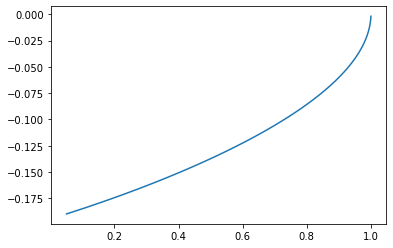

tensor([0.7684], grad_fn=<SigmoidBackward>)
tensor([0.7684], grad_fn=<SigmoidBackward>)
tensor([0.7684], grad_fn=<SigmoidBackward>)
tensor([0.7685], grad_fn=<SigmoidBackward>)
tensor([0.7685], grad_fn=<SigmoidBackward>)
tensor([0.7685], grad_fn=<SigmoidBackward>)
tensor([0.7686], grad_fn=<SigmoidBackward>)
tensor([0.7686], grad_fn=<SigmoidBackward>)
tensor([0.7687], grad_fn=<SigmoidBackward>)
tensor([0.7688], grad_fn=<SigmoidBackward>)
tensor([0.7688], grad_fn=<SigmoidBackward>)
tensor([0.7689], grad_fn=<SigmoidBackward>)
tensor([0.7689], grad_fn=<SigmoidBackward>)
tensor([0.7690], grad_fn=<SigmoidBackward>)
tensor([0.7691], grad_fn=<SigmoidBackward>)
tensor([0.7692], grad_fn=<SigmoidBackward>)
tensor([0.7693], grad_fn=<SigmoidBackward>)
tensor([0.7693], grad_fn=<SigmoidBackward>)
tensor([0.7694], grad_fn=<SigmoidBackward>)
tensor([0.7695], grad_fn=<SigmoidBackward>)
tensor([0.7696], grad_fn=<SigmoidBackward>)
tensor([0.7697], grad_fn=<SigmoidBackward>)
tensor([0.7698], grad_fn=<Sigmoi

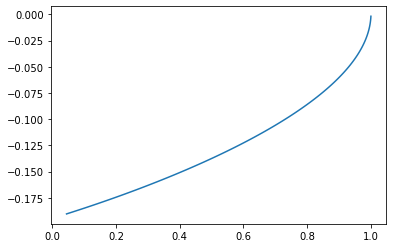

tensor([0.7693], grad_fn=<SigmoidBackward>)
tensor([0.7693], grad_fn=<SigmoidBackward>)
tensor([0.7693], grad_fn=<SigmoidBackward>)
tensor([0.7694], grad_fn=<SigmoidBackward>)
tensor([0.7694], grad_fn=<SigmoidBackward>)
tensor([0.7694], grad_fn=<SigmoidBackward>)
tensor([0.7695], grad_fn=<SigmoidBackward>)
tensor([0.7695], grad_fn=<SigmoidBackward>)
tensor([0.7696], grad_fn=<SigmoidBackward>)
tensor([0.7696], grad_fn=<SigmoidBackward>)
tensor([0.7697], grad_fn=<SigmoidBackward>)
tensor([0.7698], grad_fn=<SigmoidBackward>)
tensor([0.7698], grad_fn=<SigmoidBackward>)
tensor([0.7699], grad_fn=<SigmoidBackward>)
tensor([0.7700], grad_fn=<SigmoidBackward>)
tensor([0.7700], grad_fn=<SigmoidBackward>)
tensor([0.7701], grad_fn=<SigmoidBackward>)
tensor([0.7702], grad_fn=<SigmoidBackward>)
tensor([0.7703], grad_fn=<SigmoidBackward>)
tensor([0.7703], grad_fn=<SigmoidBackward>)
tensor([0.7704], grad_fn=<SigmoidBackward>)
tensor([0.7705], grad_fn=<SigmoidBackward>)
tensor([0.7706], grad_fn=<Sigmoi

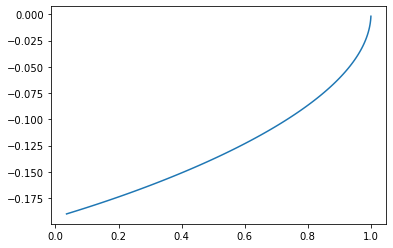

tensor([0.7717], grad_fn=<SigmoidBackward>)
tensor([0.7717], grad_fn=<SigmoidBackward>)
tensor([0.7717], grad_fn=<SigmoidBackward>)
tensor([0.7718], grad_fn=<SigmoidBackward>)
tensor([0.7718], grad_fn=<SigmoidBackward>)
tensor([0.7718], grad_fn=<SigmoidBackward>)
tensor([0.7719], grad_fn=<SigmoidBackward>)
tensor([0.7719], grad_fn=<SigmoidBackward>)
tensor([0.7719], grad_fn=<SigmoidBackward>)
tensor([0.7720], grad_fn=<SigmoidBackward>)
tensor([0.7720], grad_fn=<SigmoidBackward>)
tensor([0.7721], grad_fn=<SigmoidBackward>)
tensor([0.7721], grad_fn=<SigmoidBackward>)
tensor([0.7722], grad_fn=<SigmoidBackward>)
tensor([0.7722], grad_fn=<SigmoidBackward>)
tensor([0.7723], grad_fn=<SigmoidBackward>)
tensor([0.7723], grad_fn=<SigmoidBackward>)
tensor([0.7724], grad_fn=<SigmoidBackward>)
tensor([0.7724], grad_fn=<SigmoidBackward>)
tensor([0.7725], grad_fn=<SigmoidBackward>)
tensor([0.7725], grad_fn=<SigmoidBackward>)
tensor([0.7726], grad_fn=<SigmoidBackward>)
tensor([0.7726], grad_fn=<Sigmoi

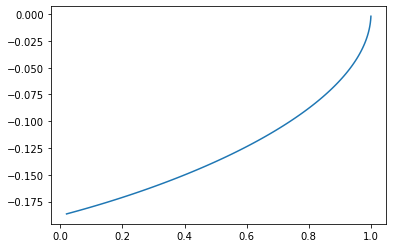

tensor([0.7768], grad_fn=<SigmoidBackward>)
tensor([0.7768], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7770], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7769], grad_fn=<SigmoidBackward>)
tensor([0.7768], grad_fn=<SigmoidBackward>)
tensor([0.7768], grad_fn=<Sigmoi

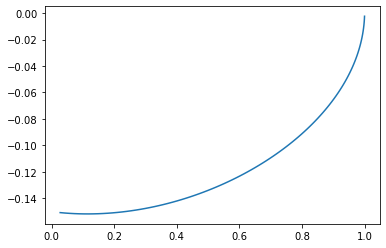

tensor([0.7935], grad_fn=<SigmoidBackward>)
tensor([0.7935], grad_fn=<SigmoidBackward>)
tensor([0.7935], grad_fn=<SigmoidBackward>)
tensor([0.7935], grad_fn=<SigmoidBackward>)
tensor([0.7935], grad_fn=<SigmoidBackward>)
tensor([0.7934], grad_fn=<SigmoidBackward>)
tensor([0.7933], grad_fn=<SigmoidBackward>)
tensor([0.7932], grad_fn=<SigmoidBackward>)
tensor([0.7931], grad_fn=<SigmoidBackward>)
tensor([0.7929], grad_fn=<SigmoidBackward>)
tensor([0.7928], grad_fn=<SigmoidBackward>)
tensor([0.7926], grad_fn=<SigmoidBackward>)
tensor([0.7924], grad_fn=<SigmoidBackward>)
tensor([0.7921], grad_fn=<SigmoidBackward>)
tensor([0.7919], grad_fn=<SigmoidBackward>)
tensor([0.7916], grad_fn=<SigmoidBackward>)
tensor([0.7913], grad_fn=<SigmoidBackward>)
tensor([0.7910], grad_fn=<SigmoidBackward>)
tensor([0.7906], grad_fn=<SigmoidBackward>)
tensor([0.7902], grad_fn=<SigmoidBackward>)
tensor([0.7898], grad_fn=<SigmoidBackward>)
tensor([0.7894], grad_fn=<SigmoidBackward>)
tensor([0.7890], grad_fn=<Sigmoi

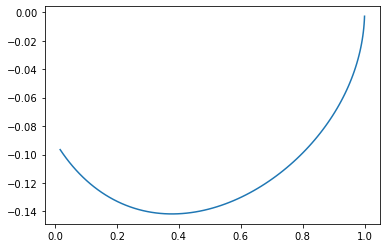

tensor([0.8203], grad_fn=<SigmoidBackward>)
tensor([0.8204], grad_fn=<SigmoidBackward>)
tensor([0.8203], grad_fn=<SigmoidBackward>)
tensor([0.8203], grad_fn=<SigmoidBackward>)
tensor([0.8202], grad_fn=<SigmoidBackward>)
tensor([0.8200], grad_fn=<SigmoidBackward>)
tensor([0.8199], grad_fn=<SigmoidBackward>)
tensor([0.8196], grad_fn=<SigmoidBackward>)
tensor([0.8194], grad_fn=<SigmoidBackward>)
tensor([0.8191], grad_fn=<SigmoidBackward>)
tensor([0.8187], grad_fn=<SigmoidBackward>)
tensor([0.8183], grad_fn=<SigmoidBackward>)
tensor([0.8179], grad_fn=<SigmoidBackward>)
tensor([0.8174], grad_fn=<SigmoidBackward>)
tensor([0.8169], grad_fn=<SigmoidBackward>)
tensor([0.8163], grad_fn=<SigmoidBackward>)
tensor([0.8157], grad_fn=<SigmoidBackward>)
tensor([0.8150], grad_fn=<SigmoidBackward>)
tensor([0.8143], grad_fn=<SigmoidBackward>)
tensor([0.8136], grad_fn=<SigmoidBackward>)
tensor([0.8128], grad_fn=<SigmoidBackward>)
tensor([0.8119], grad_fn=<SigmoidBackward>)
tensor([0.8110], grad_fn=<Sigmoi

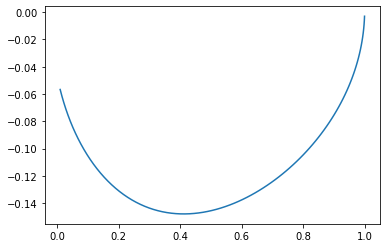

tensor([0.8376], grad_fn=<SigmoidBackward>)
tensor([0.8376], grad_fn=<SigmoidBackward>)
tensor([0.8376], grad_fn=<SigmoidBackward>)
tensor([0.8376], grad_fn=<SigmoidBackward>)
tensor([0.8375], grad_fn=<SigmoidBackward>)
tensor([0.8373], grad_fn=<SigmoidBackward>)
tensor([0.8371], grad_fn=<SigmoidBackward>)
tensor([0.8369], grad_fn=<SigmoidBackward>)
tensor([0.8366], grad_fn=<SigmoidBackward>)
tensor([0.8363], grad_fn=<SigmoidBackward>)
tensor([0.8359], grad_fn=<SigmoidBackward>)
tensor([0.8355], grad_fn=<SigmoidBackward>)
tensor([0.8350], grad_fn=<SigmoidBackward>)
tensor([0.8344], grad_fn=<SigmoidBackward>)
tensor([0.8338], grad_fn=<SigmoidBackward>)
tensor([0.8332], grad_fn=<SigmoidBackward>)
tensor([0.8325], grad_fn=<SigmoidBackward>)
tensor([0.8317], grad_fn=<SigmoidBackward>)
tensor([0.8309], grad_fn=<SigmoidBackward>)
tensor([0.8300], grad_fn=<SigmoidBackward>)
tensor([0.8290], grad_fn=<SigmoidBackward>)
tensor([0.8280], grad_fn=<SigmoidBackward>)
tensor([0.8270], grad_fn=<Sigmoi

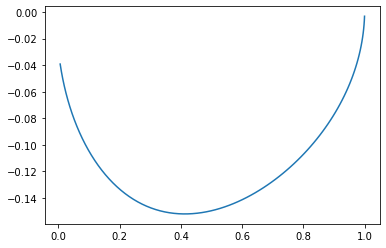

tensor([0.8448], grad_fn=<SigmoidBackward>)
tensor([0.8448], grad_fn=<SigmoidBackward>)
tensor([0.8449], grad_fn=<SigmoidBackward>)
tensor([0.8448], grad_fn=<SigmoidBackward>)
tensor([0.8447], grad_fn=<SigmoidBackward>)
tensor([0.8446], grad_fn=<SigmoidBackward>)
tensor([0.8444], grad_fn=<SigmoidBackward>)
tensor([0.8442], grad_fn=<SigmoidBackward>)
tensor([0.8439], grad_fn=<SigmoidBackward>)
tensor([0.8435], grad_fn=<SigmoidBackward>)
tensor([0.8432], grad_fn=<SigmoidBackward>)
tensor([0.8427], grad_fn=<SigmoidBackward>)
tensor([0.8422], grad_fn=<SigmoidBackward>)
tensor([0.8417], grad_fn=<SigmoidBackward>)
tensor([0.8411], grad_fn=<SigmoidBackward>)
tensor([0.8404], grad_fn=<SigmoidBackward>)
tensor([0.8397], grad_fn=<SigmoidBackward>)
tensor([0.8389], grad_fn=<SigmoidBackward>)
tensor([0.8380], grad_fn=<SigmoidBackward>)
tensor([0.8371], grad_fn=<SigmoidBackward>)
tensor([0.8362], grad_fn=<SigmoidBackward>)
tensor([0.8351], grad_fn=<SigmoidBackward>)
tensor([0.8340], grad_fn=<Sigmoi

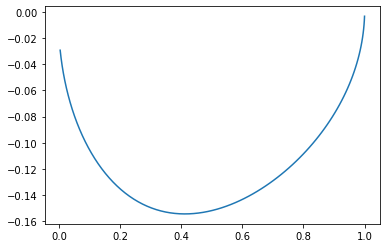

tensor([0.8488], grad_fn=<SigmoidBackward>)
tensor([0.8488], grad_fn=<SigmoidBackward>)
tensor([0.8489], grad_fn=<SigmoidBackward>)
tensor([0.8488], grad_fn=<SigmoidBackward>)
tensor([0.8487], grad_fn=<SigmoidBackward>)
tensor([0.8486], grad_fn=<SigmoidBackward>)
tensor([0.8484], grad_fn=<SigmoidBackward>)
tensor([0.8482], grad_fn=<SigmoidBackward>)
tensor([0.8479], grad_fn=<SigmoidBackward>)
tensor([0.8476], grad_fn=<SigmoidBackward>)
tensor([0.8472], grad_fn=<SigmoidBackward>)
tensor([0.8467], grad_fn=<SigmoidBackward>)
tensor([0.8462], grad_fn=<SigmoidBackward>)
tensor([0.8457], grad_fn=<SigmoidBackward>)
tensor([0.8451], grad_fn=<SigmoidBackward>)
tensor([0.8444], grad_fn=<SigmoidBackward>)
tensor([0.8437], grad_fn=<SigmoidBackward>)
tensor([0.8429], grad_fn=<SigmoidBackward>)
tensor([0.8421], grad_fn=<SigmoidBackward>)
tensor([0.8411], grad_fn=<SigmoidBackward>)
tensor([0.8401], grad_fn=<SigmoidBackward>)
tensor([0.8391], grad_fn=<SigmoidBackward>)
tensor([0.8380], grad_fn=<Sigmoi

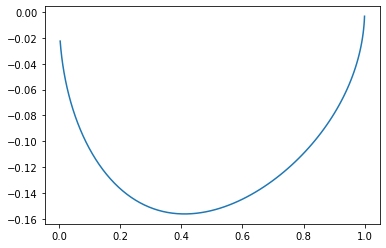

tensor([0.8514], grad_fn=<SigmoidBackward>)
tensor([0.8514], grad_fn=<SigmoidBackward>)
tensor([0.8514], grad_fn=<SigmoidBackward>)
tensor([0.8514], grad_fn=<SigmoidBackward>)
tensor([0.8513], grad_fn=<SigmoidBackward>)
tensor([0.8512], grad_fn=<SigmoidBackward>)
tensor([0.8510], grad_fn=<SigmoidBackward>)
tensor([0.8508], grad_fn=<SigmoidBackward>)
tensor([0.8505], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8498], grad_fn=<SigmoidBackward>)
tensor([0.8494], grad_fn=<SigmoidBackward>)
tensor([0.8489], grad_fn=<SigmoidBackward>)
tensor([0.8483], grad_fn=<SigmoidBackward>)
tensor([0.8477], grad_fn=<SigmoidBackward>)
tensor([0.8470], grad_fn=<SigmoidBackward>)
tensor([0.8463], grad_fn=<SigmoidBackward>)
tensor([0.8455], grad_fn=<SigmoidBackward>)
tensor([0.8447], grad_fn=<SigmoidBackward>)
tensor([0.8438], grad_fn=<SigmoidBackward>)
tensor([0.8428], grad_fn=<SigmoidBackward>)
tensor([0.8417], grad_fn=<SigmoidBackward>)
tensor([0.8406], grad_fn=<Sigmoi

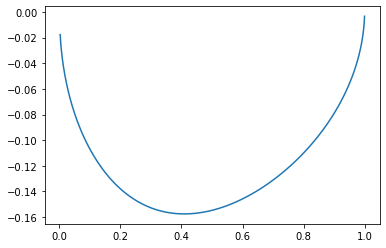

tensor([0.8531], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8531], grad_fn=<SigmoidBackward>)
tensor([0.8530], grad_fn=<SigmoidBackward>)
tensor([0.8528], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8523], grad_fn=<SigmoidBackward>)
tensor([0.8520], grad_fn=<SigmoidBackward>)
tensor([0.8516], grad_fn=<SigmoidBackward>)
tensor([0.8512], grad_fn=<SigmoidBackward>)
tensor([0.8507], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8496], grad_fn=<SigmoidBackward>)
tensor([0.8489], grad_fn=<SigmoidBackward>)
tensor([0.8482], grad_fn=<SigmoidBackward>)
tensor([0.8474], grad_fn=<SigmoidBackward>)
tensor([0.8465], grad_fn=<SigmoidBackward>)
tensor([0.8456], grad_fn=<SigmoidBackward>)
tensor([0.8446], grad_fn=<SigmoidBackward>)
tensor([0.8436], grad_fn=<SigmoidBackward>)
tensor([0.8424], grad_fn=<Sigmoi

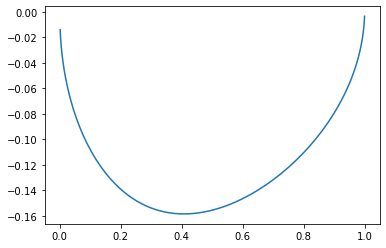

tensor([0.8544], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8544], grad_fn=<SigmoidBackward>)
tensor([0.8543], grad_fn=<SigmoidBackward>)
tensor([0.8541], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8537], grad_fn=<SigmoidBackward>)
tensor([0.8533], grad_fn=<SigmoidBackward>)
tensor([0.8529], grad_fn=<SigmoidBackward>)
tensor([0.8525], grad_fn=<SigmoidBackward>)
tensor([0.8520], grad_fn=<SigmoidBackward>)
tensor([0.8515], grad_fn=<SigmoidBackward>)
tensor([0.8509], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8495], grad_fn=<SigmoidBackward>)
tensor([0.8487], grad_fn=<SigmoidBackward>)
tensor([0.8479], grad_fn=<SigmoidBackward>)
tensor([0.8470], grad_fn=<SigmoidBackward>)
tensor([0.8460], grad_fn=<SigmoidBackward>)
tensor([0.8449], grad_fn=<SigmoidBackward>)
tensor([0.8438], grad_fn=<Sigmoi

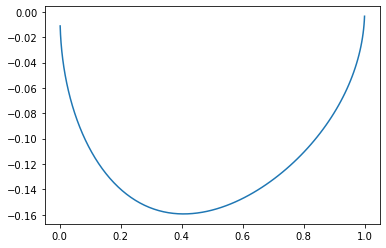

tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8555], grad_fn=<SigmoidBackward>)
tensor([0.8555], grad_fn=<SigmoidBackward>)
tensor([0.8555], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8553], grad_fn=<SigmoidBackward>)
tensor([0.8551], grad_fn=<SigmoidBackward>)
tensor([0.8549], grad_fn=<SigmoidBackward>)
tensor([0.8546], grad_fn=<SigmoidBackward>)
tensor([0.8543], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8535], grad_fn=<SigmoidBackward>)
tensor([0.8530], grad_fn=<SigmoidBackward>)
tensor([0.8525], grad_fn=<SigmoidBackward>)
tensor([0.8519], grad_fn=<SigmoidBackward>)
tensor([0.8512], grad_fn=<SigmoidBackward>)
tensor([0.8505], grad_fn=<SigmoidBackward>)
tensor([0.8497], grad_fn=<SigmoidBackward>)
tensor([0.8489], grad_fn=<SigmoidBackward>)
tensor([0.8480], grad_fn=<SigmoidBackward>)
tensor([0.8470], grad_fn=<SigmoidBackward>)
tensor([0.8460], grad_fn=<SigmoidBackward>)
tensor([0.8448], grad_fn=<Sigmoi

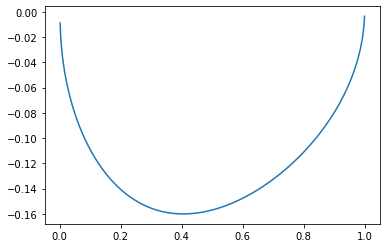

tensor([0.8560], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8559], grad_fn=<SigmoidBackward>)
tensor([0.8558], grad_fn=<SigmoidBackward>)
tensor([0.8556], grad_fn=<SigmoidBackward>)
tensor([0.8553], grad_fn=<SigmoidBackward>)
tensor([0.8550], grad_fn=<SigmoidBackward>)
tensor([0.8546], grad_fn=<SigmoidBackward>)
tensor([0.8542], grad_fn=<SigmoidBackward>)
tensor([0.8537], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8519], grad_fn=<SigmoidBackward>)
tensor([0.8512], grad_fn=<SigmoidBackward>)
tensor([0.8505], grad_fn=<SigmoidBackward>)
tensor([0.8496], grad_fn=<SigmoidBackward>)
tensor([0.8487], grad_fn=<SigmoidBackward>)
tensor([0.8478], grad_fn=<SigmoidBackward>)
tensor([0.8467], grad_fn=<SigmoidBackward>)
tensor([0.8456], grad_fn=<Sigmoi

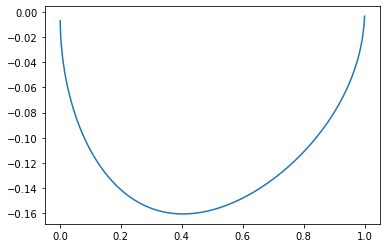

tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8566], grad_fn=<SigmoidBackward>)
tensor([0.8566], grad_fn=<SigmoidBackward>)
tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8564], grad_fn=<SigmoidBackward>)
tensor([0.8562], grad_fn=<SigmoidBackward>)
tensor([0.8560], grad_fn=<SigmoidBackward>)
tensor([0.8557], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8551], grad_fn=<SigmoidBackward>)
tensor([0.8546], grad_fn=<SigmoidBackward>)
tensor([0.8542], grad_fn=<SigmoidBackward>)
tensor([0.8536], grad_fn=<SigmoidBackward>)
tensor([0.8531], grad_fn=<SigmoidBackward>)
tensor([0.8524], grad_fn=<SigmoidBackward>)
tensor([0.8517], grad_fn=<SigmoidBackward>)
tensor([0.8510], grad_fn=<SigmoidBackward>)
tensor([0.8501], grad_fn=<SigmoidBackward>)
tensor([0.8492], grad_fn=<SigmoidBackward>)
tensor([0.8483], grad_fn=<SigmoidBackward>)
tensor([0.8472], grad_fn=<SigmoidBackward>)
tensor([0.8461], grad_fn=<Sigmoi

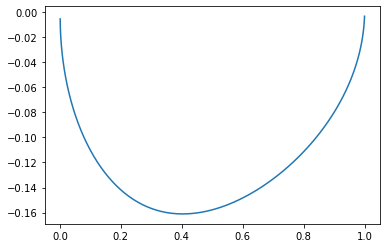

tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8568], grad_fn=<SigmoidBackward>)
tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8568], grad_fn=<SigmoidBackward>)
tensor([0.8568], grad_fn=<SigmoidBackward>)
tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8563], grad_fn=<SigmoidBackward>)
tensor([0.8560], grad_fn=<SigmoidBackward>)
tensor([0.8557], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8550], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8540], grad_fn=<SigmoidBackward>)
tensor([0.8534], grad_fn=<SigmoidBackward>)
tensor([0.8528], grad_fn=<SigmoidBackward>)
tensor([0.8521], grad_fn=<SigmoidBackward>)
tensor([0.8513], grad_fn=<SigmoidBackward>)
tensor([0.8505], grad_fn=<SigmoidBackward>)
tensor([0.8496], grad_fn=<SigmoidBackward>)
tensor([0.8486], grad_fn=<SigmoidBackward>)
tensor([0.8476], grad_fn=<SigmoidBackward>)
tensor([0.8465], grad_fn=<Sigmoi

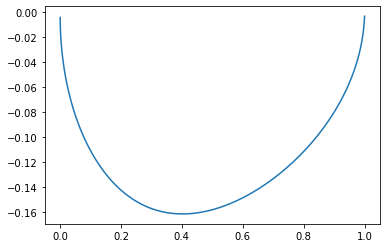

tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8562], grad_fn=<SigmoidBackward>)
tensor([0.8559], grad_fn=<SigmoidBackward>)
tensor([0.8556], grad_fn=<SigmoidBackward>)
tensor([0.8552], grad_fn=<SigmoidBackward>)
tensor([0.8547], grad_fn=<SigmoidBackward>)
tensor([0.8542], grad_fn=<SigmoidBackward>)
tensor([0.8536], grad_fn=<SigmoidBackward>)
tensor([0.8530], grad_fn=<SigmoidBackward>)
tensor([0.8523], grad_fn=<SigmoidBackward>)
tensor([0.8515], grad_fn=<SigmoidBackward>)
tensor([0.8507], grad_fn=<SigmoidBackward>)
tensor([0.8499], grad_fn=<SigmoidBackward>)
tensor([0.8489], grad_fn=<SigmoidBackward>)
tensor([0.8479], grad_fn=<SigmoidBackward>)
tensor([0.8468], grad_fn=<Sigmoi

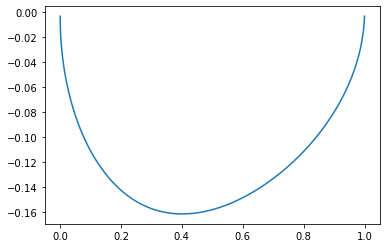

tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8568], grad_fn=<SigmoidBackward>)
tensor([0.8566], grad_fn=<SigmoidBackward>)
tensor([0.8564], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8557], grad_fn=<SigmoidBackward>)
tensor([0.8553], grad_fn=<SigmoidBackward>)
tensor([0.8549], grad_fn=<SigmoidBackward>)
tensor([0.8543], grad_fn=<SigmoidBackward>)
tensor([0.8538], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8525], grad_fn=<SigmoidBackward>)
tensor([0.8517], grad_fn=<SigmoidBackward>)
tensor([0.8509], grad_fn=<SigmoidBackward>)
tensor([0.8500], grad_fn=<SigmoidBackward>)
tensor([0.8491], grad_fn=<SigmoidBackward>)
tensor([0.8481], grad_fn=<SigmoidBackward>)
tensor([0.8470], grad_fn=<Sigmoi

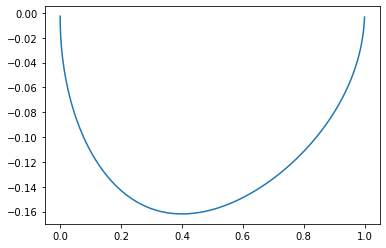

tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8564], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8558], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8549], grad_fn=<SigmoidBackward>)
tensor([0.8544], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8532], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8518], grad_fn=<SigmoidBackward>)
tensor([0.8510], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8492], grad_fn=<SigmoidBackward>)
tensor([0.8482], grad_fn=<SigmoidBackward>)
tensor([0.8471], grad_fn=<Sigmoi

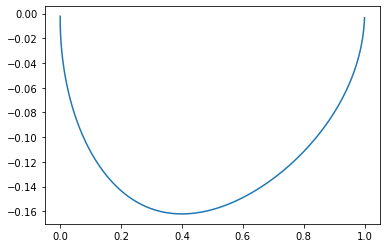

tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8565], grad_fn=<SigmoidBackward>)
tensor([0.8562], grad_fn=<SigmoidBackward>)
tensor([0.8558], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8550], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8533], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8519], grad_fn=<SigmoidBackward>)
tensor([0.8511], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8493], grad_fn=<SigmoidBackward>)
tensor([0.8483], grad_fn=<SigmoidBackward>)
tensor([0.8472], grad_fn=<Sigmoi

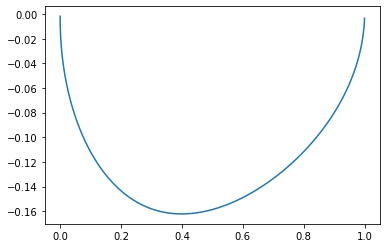

tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8572], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8569], grad_fn=<SigmoidBackward>)
tensor([0.8567], grad_fn=<SigmoidBackward>)
tensor([0.8564], grad_fn=<SigmoidBackward>)
tensor([0.8562], grad_fn=<SigmoidBackward>)
tensor([0.8558], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8550], grad_fn=<SigmoidBackward>)
tensor([0.8545], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8533], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8519], grad_fn=<SigmoidBackward>)
tensor([0.8511], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8493], grad_fn=<SigmoidBackward>)
tensor([0.8483], grad_fn=<SigmoidBackward>)
tensor([0.8473], grad_fn=<Sigmoi

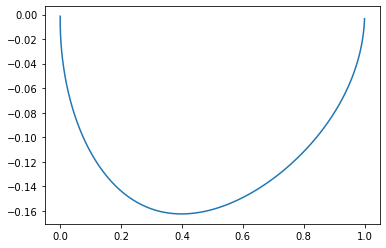

tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8571], grad_fn=<SigmoidBackward>)
tensor([0.8570], grad_fn=<SigmoidBackward>)
tensor([0.8568], grad_fn=<SigmoidBackward>)
tensor([0.8566], grad_fn=<SigmoidBackward>)
tensor([0.8564], grad_fn=<SigmoidBackward>)
tensor([0.8561], grad_fn=<SigmoidBackward>)
tensor([0.8558], grad_fn=<SigmoidBackward>)
tensor([0.8554], grad_fn=<SigmoidBackward>)
tensor([0.8549], grad_fn=<SigmoidBackward>)
tensor([0.8544], grad_fn=<SigmoidBackward>)
tensor([0.8539], grad_fn=<SigmoidBackward>)
tensor([0.8533], grad_fn=<SigmoidBackward>)
tensor([0.8526], grad_fn=<SigmoidBackward>)
tensor([0.8519], grad_fn=<SigmoidBackward>)
tensor([0.8511], grad_fn=<SigmoidBackward>)
tensor([0.8502], grad_fn=<SigmoidBackward>)
tensor([0.8493], grad_fn=<SigmoidBackward>)
tensor([0.8483], grad_fn=<SigmoidBackward>)
tensor([0.8473], grad_fn=<Sigmoi

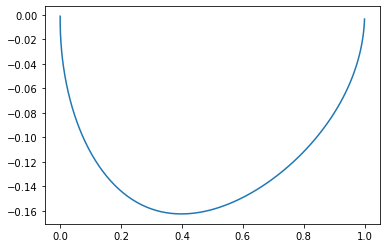

Landing Trajectory:


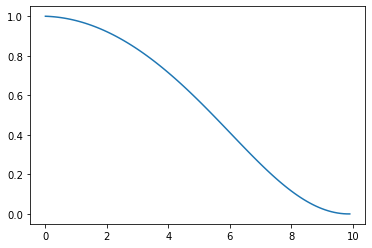

In [8]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

